In [10]:
import pathlib

from rdkit import Chem
from rdkit.Chem import rdDistGeom
from mace.calculators import mace_off
import numpy as np

import ase
import ase.io as aio
from ase import units as ase_units
from ase.visualize import view
from ase.optimize import FIRE
from ase.md import Langevin
import pandas as pd
from simgen.calculators import MaceSimilarityCalculator

In [19]:
df = pd.read_csv("./fda_approved_drugs.txt", sep="\t")
df = df.query("~smiles.isna()")
penicillin_smiles = df.query("generic_name == 'Penicillin G'")["smiles"].values[0]
penicillin_mol = Chem.MolFromSmiles(penicillin_smiles)
penicillin_mol = Chem.AddHs(penicillin_mol)
symbols = [atom.GetSymbol() for atom in penicillin_mol.GetAtoms()]
pdb_traj = aio.read("penicillin_trajectory.pdb", index=":")
conformers = pdb_traj[::100]

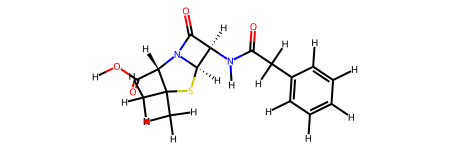

In [20]:
penicillin_mol

In [21]:
patt = Chem.MolFromSmarts("O=C1CC2N1CCS2")
core_ids = np.asarray(penicillin_mol.GetSubstructMatch(patt)).flatten()    

In [22]:
# Collect short MD trajectory to get multiple conformations
calc = mace_off("medium", device="cuda", default_dtype="float32")
for atoms in conformers:
    atoms.calc = calc
    dyn = FIRE(atoms)
    dyn.run(fmax=0.1)
    atoms.calc = None

Using MACE-OFF23 MODEL for MACECalculator with /home/rokas/.cache/mace/MACE-OFF23_medium.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/rokas/miniconda3/envs/genesis/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loc

Default dtype float32 does not match model dtype float64, converting models to float32.
      Step     Time          Energy          fmax
FIRE:    0 16:58:11   -38908.597656        7.277796
FIRE:    1 16:58:11   -38909.457031        4.953699
FIRE:    2 16:58:11   -38909.593750        2.922169
FIRE:    3 16:58:11   -38909.761719        2.588393
FIRE:    4 16:58:11   -38909.878906        3.623555
FIRE:    5 16:58:11   -38910.027344        3.426571
FIRE:    6 16:58:11   -38910.199219        1.911121
FIRE:    7 16:58:12   -38910.304688        0.957311
FIRE:    8 16:58:12   -38910.375000        2.115288
FIRE:    9 16:58:12   -38910.449219        1.679210
FIRE:   10 16:58:12   -38910.519531        0.975016
FIRE:   11 16:58:12   -38910.542969        1.828880
FIRE:   12 16:58:12   -38910.558594        1.553292
FIRE:   13 16:58:12   -38910.578125        1.076645
FIRE:   14 16:58:12   -38910.601562        0.701642
FIRE:   15 16:58:12   -38910.613281        0.952525
FIRE:   16 16:58:13   -38910.6

In [23]:
z_table = calc.z_table
atoms = conformers[0]
core_atom_mask = np.zeros(len(atoms), dtype=bool)
core_atom_mask[core_ids] = True

In [42]:
element_sigma_array = np.ones_like(z_table.zs)*0.5
sim_calc = MaceSimilarityCalculator(
    model=calc.models[0],
    reference_data=conformers,
    ref_data_mask=[core_atom_mask]*len(conformers),
    element_sigma_array=element_sigma_array,
    max_norm=None,
    device="cuda",
)

In [43]:
from torch_scatter import scatter_logsumexp

In [44]:
# read sdf files
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

In [45]:
sdf_path = pathlib.Path("./results_inverse_summation/exp_28/SDF")
sdf_files = list(sdf_path.glob("*.sdf"))
mols = []
for sdf_file in sdf_files:
    suppl = Chem.SDMolSupplier(str(sdf_file))
    for mol in suppl:
        if mol is not None:
            mols.append(mol)

In [46]:
def rdkit_mol_2_ase(mol):
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    positions = mol.GetConformer().GetPositions()
    return ase.Atoms(symbols, positions)

In [47]:
generated_densities = np.zeros((len(mols)))
batch_size = 32
noise_level = 1.
for start_idx in range(0, len(mols), batch_size):
    end_idx = min(start_idx+batch_size, len(mols))
    mols_batch = mols[start_idx:start_idx+batch_size]
    atoms_batch = [rdkit_mol_2_ase(mol) for mol in mols_batch]
    batch = sim_calc.batch_atoms(atoms_batch)
    embeddings = sim_calc._get_node_embeddings(batch)
    squared_distance_matrix = sim_calc._calculate_distance_matrix(embeddings, batch.node_attrs)
    additional_multiplier = 119 * (1 - (noise_level / 10) ** 0.25) + 1 if noise_level <= 10 else 1
    squared_distance_matrix = squared_distance_matrix * additional_multiplier # (N_config_atoms, N_ref_atoms)
    log_dens = scatter_logsumexp(-squared_distance_matrix / 2, batch.batch, dim=0) # (N_graphs, N_ref_atoms)
    log_dens = log_dens.sum(dim=-1) # (N_graphs,)
    generated_densities[start_idx:end_idx] = log_dens.detach().cpu().numpy()

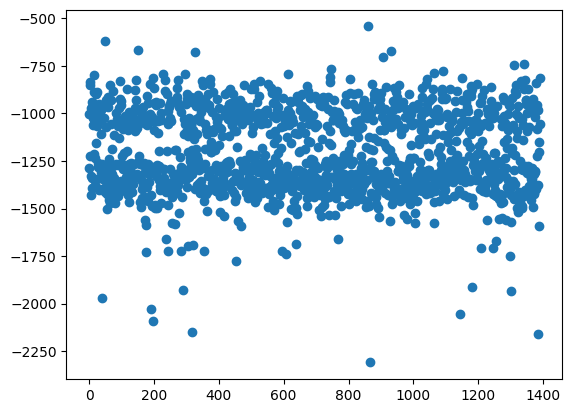

In [48]:
plt.scatter(np.arange(len(mols)), generated_densities)

In [49]:
np.argsort(generated_densities)[-10:]

array([1092,  747, 1310, 1341,  905,  328,  932,  152,   49,  859])

In [52]:
noise_level = 0.5
simgen_batch = sim_calc.batch_atoms([atoms, atoms[core_atom_mask], rdkit_mol_2_ase(mols[859])])
embeddings = sim_calc._get_node_embeddings(simgen_batch)

squared_distance_matrix = sim_calc._calculate_distance_matrix(embeddings, simgen_batch.node_attrs)
additional_multiplier = 119 * (1 - (noise_level / 10) ** 0.25) + 1 if noise_level <= 10 else 1
squared_distance_matrix = squared_distance_matrix * additional_multiplier # (N_config_atoms, N_ref_atoms)
log_dens = scatter_logsumexp(-squared_distance_matrix / 2, simgen_batch.batch, dim=0) # (N_graphs, N_ref_atoms)
log_dens = log_dens.sum(dim=-1) # (N_graphs,)
forces = sim_calc._get_gradient(simgen_batch.positions, log_dens)

In [53]:
log_dens

tensor([    1.2793, -1244.7175,  -654.8451], device='cuda:0',
       grad_fn=<SumBackward1>)

In [54]:
forces[:len(atoms)], forces[len(atoms):]

(tensor([[ 1.9483e+01,  7.8086e+00, -2.0385e-01],
         [-3.9808e+00, -1.6634e+01,  1.2885e+01],
         [-6.0350e+00,  1.2108e+01, -1.8229e+01],
         [ 5.4580e+00, -4.6056e+00, -6.2158e+00],
         [-8.7178e+00, -1.9016e+00, -1.0044e+00],
         [ 1.3344e+01, -1.2089e+01,  1.8405e+01],
         [-1.0892e+01,  8.5348e+00, -1.7013e+01],
         [ 2.9840e+00, -2.7748e+00, -3.0913e+00],
         [-1.7023e-01, -1.6053e+00, -6.7064e-01],
         [-5.5518e+00, -5.9380e+00,  5.2607e+00],
         [ 1.9034e+00,  1.6027e+01,  3.4293e+00],
         [-1.8812e+01, -2.1256e+01, -2.1978e+01],
         [ 8.0643e+00,  4.2901e+00,  9.7221e+00],
         [ 5.6216e+00,  4.0343e-01,  7.8688e+00],
         [ 6.3399e-01,  2.6572e-01,  1.1999e+00],
         [ 1.1505e+00, -1.2129e+00, -3.4321e-01],
         [ 3.3480e-01, -3.8081e-01,  4.7214e-01],
         [ 5.6951e-02, -1.9991e-02,  4.2022e-02],
         [-2.4802e-02, -2.8838e-02, -2.2692e-02],
         [-8.0294e-01, -4.8942e-01, -3.0207e-01],


In [14]:
atoms.info["calculation_type"] = "similarity"
atoms.info["time"] = 0.1
sim_calc.get_potential_energies(atoms)

array([-2.7131485e-02,  1.5595867e-12, -4.1559484e-02,  8.4436760e+00,
        8.5579748e+00, -5.4600157e-02,  5.7608931e-13,  1.8012048e-12,
        3.7470520e-13, -7.8069888e-02,  8.5241613e+00,  8.6595182e+00,
        1.1370305e+00,  3.3249624e+00,  1.9393549e+01,  1.9508036e+01,
        1.9793276e+01,  1.9743000e+01,  1.9775654e+01,  1.9470861e+01,
        7.9355264e+00,  1.5354022e+01,  1.4680674e+00,  3.1703062e+01,
        3.1108341e+01,  3.1523886e+01,  3.1064209e+01,  3.1751268e+01,
        3.1553583e+01,  3.1354902e+01,  3.4457939e+01,  3.1960493e+01,
        3.3785759e+01,  3.1593504e+01,  3.1536148e+01,  2.9276260e+01,
        2.9371902e+01,  2.9375990e+01,  2.9374193e+01,  2.9251598e+01,
        3.5166107e+01], dtype=float32)